Лаба 4

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import copy


1) Метод Ньютона

In [106]:
# Функция для вычисления разделённых разностей
def divided_differences(x, y):
    n = len(x)
    table = np.zeros((n, n))
    table[:, 0] = y  # Первый столбец — значения y
    
    for j in range(1, n):
        for i in range(n - j):
            table[i, j] = (table[i + 1, j - 1] - table[i, j - 1]) / (x[i + j] - x[i])
    
    return table[0, :]  # Возвращаем первую строку (коэффициенты)

In [107]:
# Функция для вычисления значения интерполяционного многочлена
def newton_polynomial(x, x_nodes, coefficients):
    n = len(coefficients)
    result = coefficients[0]
    product = 1.0
    for i in range(1, n):
        product *= (x - x_nodes[i - 1])
        result += coefficients[i] * product
    return result

In [108]:
# Данные
years = np.array([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
population = np.array([54326000, 62698000, 61794000, 65130000, 69838000, 68374000, 72664000, 77772000, 78295000, 79365000, 82163475]) / 1000000

real_years = np.array([1935, 1946, 1985, 2010])
real_population = np.array([66871000, 64260000, 77619000, 81802257]) / 1000000

In [109]:
coefficients = divided_differences(years, population)


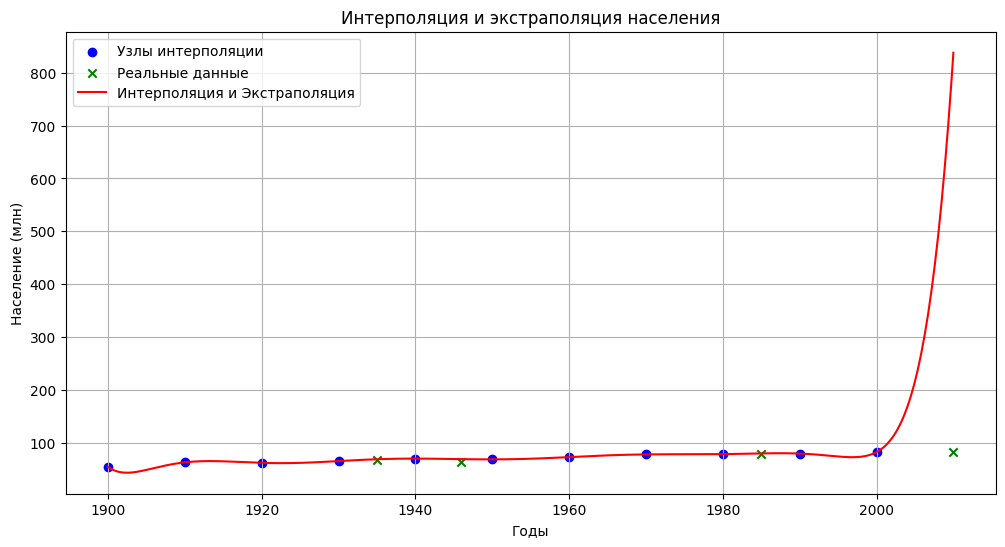

In [110]:
extrap_years = np.linspace(1900, 2010, 500)
extrap_population = [newton_polynomial(year, years, coefficients) for year in extrap_years]

# Построение графиков
plt.figure(figsize=(12, 6))

# Интерполяция
plt.scatter(years, population, label="Узлы интерполяции", color='blue')
plt.scatter(real_years, real_population, label="Реальные данные", color='green', marker='x')

# Экстраполяция
plt.plot(extrap_years, extrap_population, label="Интерполяция и Экстраполяция", linestyle="-", color='red')

# Настройки графика
plt.title("Интерполяция и экстраполяция населения")
plt.xlabel("Годы")
plt.ylabel("Население (млн)")
plt.legend()
plt.grid()
plt.show()

2) Кубический Сплайн

In [111]:
# Функции для решения СЛАУ методом Гауса из прошлой лабы

#Вычисление третей нормы вектора
def norm_3(U):
    r = 0
    for i in range(len(U)):
        r += U[i,0] * U[i,0]
        
    return np.sqrt(r)

# поиск главного элемента в матрице
def find_main_element(A, iteration):
    size = A.shape[0]
    main_element = A[iteration,iteration]
    i_main = iteration
    j_main = iteration

    for i in range(size - iteration): 
        for j in range(size - iteration):
            if abs(A[i + iteration,j + iteration]) > abs(main_element):
                i_main = i + iteration
                j_main = j + iteration
                main_element = A[i_main,j_main]
    return [i_main, j_main]

# Функция для обмена строк
def swap_rows(A, i, j):
    A[[i, j], :] = A[[j, i], :]

# Функция для обмена столбцов
def swap_columns(A, i, j):
    A[:, [i, j]] = A[:, [j, i]]
    
#Функция для обмена значений
def swap(a,b):
    return b,a

def gauss(a, f):
    
    A = copy.deepcopy(a)
    F = copy.deepcopy(f)
    
    size = len(A)  # размеры матрицы - количество переменных Х
    
    X = np.arange(size) # массив для смены порядка переменных Х
        
    for iter in range(size): # прямой ход
        
        main_indices = find_main_element(A,iter) # поиск координат главного элемента
        main_element = A[main_indices[0], main_indices[1]] # главный элемент
        
        # если главный элемент не стоит в верхней строке, делаем перестановку строк
        if(main_indices[0] - iter != 0): 
            swap_rows(A[iter:, iter:], 0, main_indices[0] - iter)
            # swap(F[iter], F[main_indices[0]])
            F[iter] = F[main_indices[0]] + F[iter]
            F[main_indices[0]] = F[iter] - F[main_indices[0]]
            F[iter] = F[iter] - F[main_indices[0]]
            
            
        # если главный элемент не стоит в левом столбце,  делаем перестановку столбцов
        if(main_indices[1] - iter != 0): 
            swap_columns(A, iter, main_indices[1])
            # swap(X[iter], X[main_indices[1]])
            X[iter] = X[main_indices[1]] + X[iter]
            X[main_indices[1]] = X[iter] - X[main_indices[1]]
            X[iter] = X[iter] - X[main_indices[1]]
        
        # делим строчку на главный элемент
        if(main_element != 0):
            A[iter:, iter:][0] =  A[iter:, iter:][0] / main_element #
            F[iter] = F[iter] / main_element
        
        # вычитаем из всех строк первую домноженную на соответсвующий множитель
        for i in range(size - iter - 1):
            F[iter + i + 1] -= (F[iter]  * A[iter:, iter:][i + 1][0])
            A[iter:, iter:][i + 1] -= (A[iter:, iter:][0] * A[iter:, iter:][i + 1][0])

    # приводим правый нижний элемент к 1
    if(A[-1,-1] != 0):
        F[-1] /= A[-1, -1]
        A[size - 1, size - 1] = 1
 
    U  = np.ones((size, 1)) # массив для решений СЛАУ
    
    # обратный ход
    for i in range(size-1, -1, -1):
        U[i] = F[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    # перестановка переменных в изначальном порядке
    result = np.ones((size, 1))
    for i in range(size):
        result[int(X[i])][0] = U[i][0]

    # возвращаем результат
    return result

In [112]:
# функция для вычисления кубического сплайна
def cubic_spline(x, y):
    
    n = len(x) - 1  # количество интервалов
    h = np.diff(x)  # длины интервалов

    # Вычисляем вектор правой части системы уравнений (f)
    f = np.zeros(n + 1)
    for i in range(1, n):
        f[i] = (3 / h[i] * (y[i + 1] - y[i]) - 3 / h[i - 1] * (y[i] - y[i - 1]))

    # Формируем матрицу A для решения системы уравнений
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)

    for i in range(1, n):
        A[i, i - 1] = h[i - 1]  # нижняя диагональ
        A[i, i] = 2 * (h[i - 1] + h[i])  # главная диагональ
        A[i, i + 1] = h[i]  # верхняя диагональ
        b[i] = f[i]

    # Граничные условия
    A[0, 0] = 1
    A[n, n] = 1
  
    # Решаем систему линейных уравнений для коэффициентов c
    c = gauss(A, b)

    # Вычисляем коэффициенты a, b, d
    a = y[:-1]
    b = np.zeros(n)
    d = np.zeros(n)

    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (2 * c[i][0] + c[i + 1][0]) / 3
        d[i] = (c[i + 1][0] - c[i][0]) / (3 * h[i])

    return a, b, c[:-1], d

In [117]:
def value_spline(x, a, b, c, d, xi):
    n = len(a)
    for i in range(n):
        if x[i] <= xi <= x[i + 1]:
            dx = xi - x[i]
            return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3

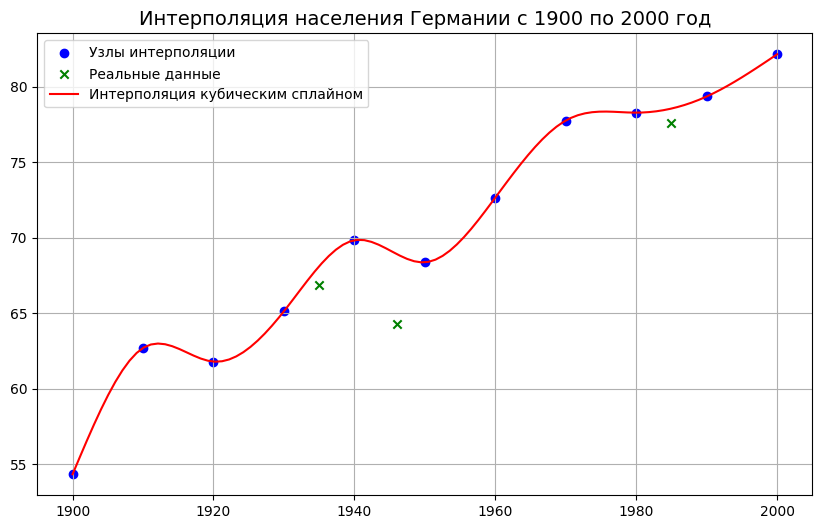

In [114]:
# Строим сплайн
a, b, c, d = cubic_spline(years, population)

# Оцениваем значение сплайна
x_dense = np.linspace(1900, 2000, 100)
y_dense = [value_spline(years, a, b, c, d, xi) for xi in x_dense]



plt.figure(figsize=(10, 6))
plt.scatter(years, population, label="Узлы интерполяции", color='blue')
plt.scatter(real_years[0:3], real_population[0:3], label="Реальные данные", color='green', marker='x')
plt.plot(x_dense, y_dense, label="Интерполяция кубическим сплайном", color = "red")

plt.legend()
plt.grid(True)
plt.title('Интерполяция населения Германии с 1900 по 2000 год', fontsize=14)
plt.show()

In [115]:
# Вычисление значения сплайна в точке xi с поддержкой экстраполяции.
def value_spline_extrapolate(x, a, b, c, d, xi):
    
    n = len(a)
    if xi < x[0]:  # Экстраполяция слева
        dx = xi - x[0]
        return a[0] + b[0] * dx + c[0] * dx**2 + d[0] * dx**3
    elif xi > x[-1]:  # Экстраполяция справа
        dx = xi - x[-1]
        return a[-1] + b[-1] * dx + c[-1] * dx**2 + d[-1] * dx**3
    else:  # Интерполяция внутри диапазона
        for i in range(n):
            if x[i] <= xi <= x[i + 1]:
                dx = xi - x[i]
                return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    raise ValueError("Ошибка вычисления: xi вне диапазона x")

In [116]:
# Вычисление значений сплайна в точке 2010
extrapolated_values = value_spline_extrapolate(years, a, b, c, d, real_years[-1])


print(f"Оценка населения в {real_years[-1]} году:, {int(extrapolated_values[-1].item())} млн человек")
print(f"Реальное  население в {real_years[-1]} году: {real_population[-1]:.0f} млн человек")

Оценка населения в 2010 году:, 82 млн человек
Реальное  население в 2010 году: 82 млн человек


3) МНК

In [102]:
def MNC(polynomial_degree, centered_years, years, population):
    
    centered_years = years - np.mean(years)
    # Инициализация матрицы для системы линейных уравнений и вектора правой части
    matrix_A = np.zeros((polynomial_degree + 1, polynomial_degree + 1))
    vector_b = np.zeros((polynomial_degree + 1, 1))

    # Заполнение матрицы A и вектора b
    for i in range(polynomial_degree + 1):
        for j in range(polynomial_degree + 1):
            matrix_A[i, j] = np.sum(centered_years ** (i + j))  # Заполнение элементов матрицы A
        vector_b[i, 0] = np.sum(population * (centered_years ** i))  # Заполнение элементов вектора b

    # Решение системы линейных уравнений для нахождения коэффициентов полинома
    return gauss(matrix_A, vector_b)

In [103]:
# Функция для вычисления значения полинома в точке x
def evaluate_polynomial(x, coefficients):
    return sum(coef * (x ** power) for power, coef in enumerate(coefficients))

In [104]:
centered_years = years - np.mean(years)

polynomial_degree = 7

polynomial_coefficients = MNC(polynomial_degree, centered_years, years, population)

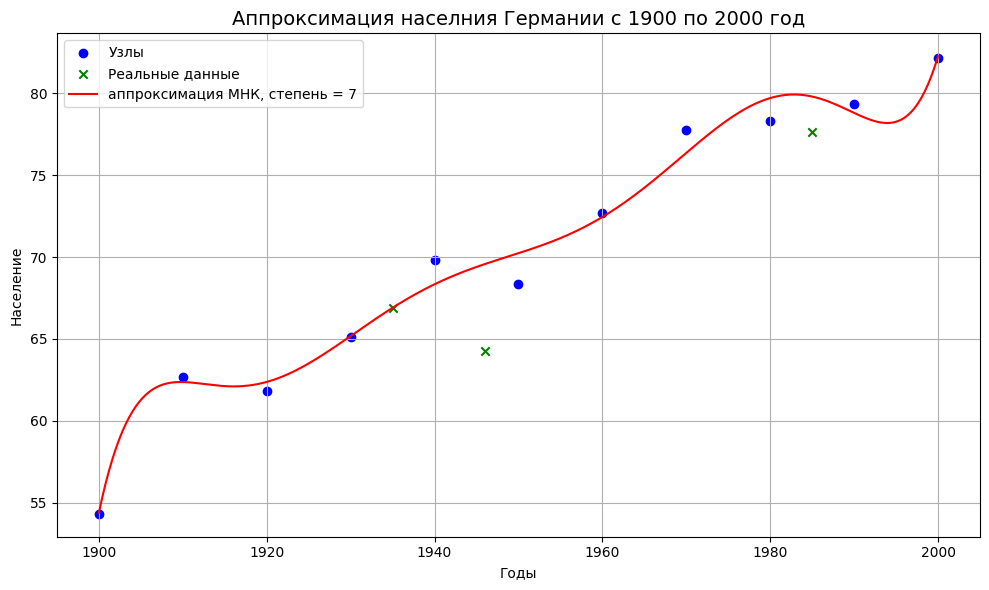

In [105]:
x_values_for_plot = np.linspace(min(centered_years), max(centered_years), 500)

y_values_for_plot = evaluate_polynomial(x_values_for_plot, polynomial_coefficients)

x_vals = np.linspace(min(centered_years), max(centered_years), 500)
y_vals = evaluate_polynomial(x_vals, polynomial_coefficients)

x_original = x_vals + np.mean(years)

plt.figure(figsize=(10, 6))
plt.scatter(years, population, label="Узлы", color='blue')
plt.scatter(real_years[0:3], real_population[0:3], label="Реальные данные", color='green', marker='x')
plt.plot(x_original, y_vals, color='red', label='аппроксимация МНК, степень = 7')
plt.xlabel('Годы')
plt.ylabel('Население')
plt.legend()
plt.grid()
plt.title('Аппроксимация населния Германии с 1900 по 2000 год', fontsize=14)
plt.tight_layout()
plt.show()

Наилучшая аппроксимация получается при n = 7